In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] =False
from arch.unitroot import ADF
df = pd.read_excel('C:\\Users\\Administrator\\Desktop\\时序.xlsx')

# 移动平均图
def draw_trend(timeseries, size):
    f = plt.figure(facecolor='white')
    # 对size个数据进行移动平均
    rol_mean = timeseries.rolling(window=size).mean()
    # 对size个数据移动平均的方差
    rol_std = timeseries.rolling(window=size).std()
    timeseries.plot(color='blue', label='Original')
    rol_mean.plot(color='red', label='Rolling Mean')
    #rol_std.plot(color='black', label='Rolling standard deviation')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

def draw_ts(timeseries):
    f = plt.figure(facecolor='white')
    timeseries.plot(color='blue')
    plt.show()
    
#draw_trend(df.iloc[:1], 2)
ADF(df.iloc[:,1])#p值为0小于0.05认为是平稳的
#draw_trend(diff_1,2)


Test Statistic,-8.319
P-value,0.000
Lags,21


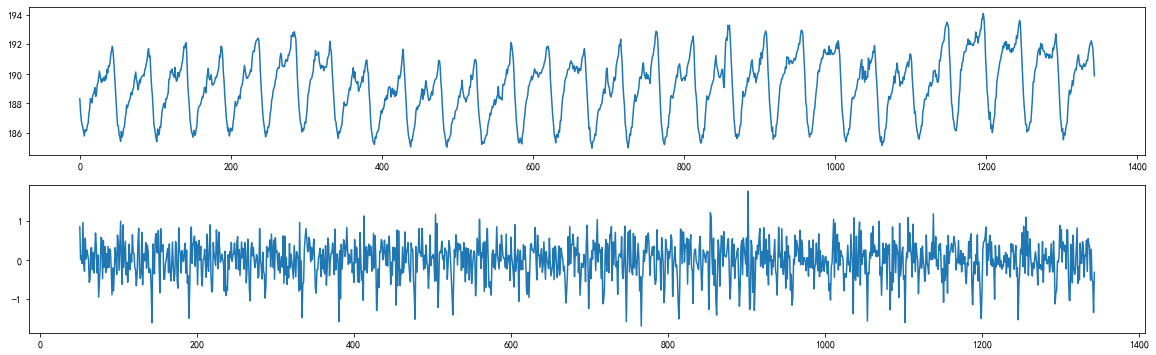

In [40]:
diff_1 = df.iloc[:,1].diff(1)
diff1 = diff_1.dropna()
diff_50 = diff_1-diff_1.shift(50)
diff_50.dropna(inplace=True)

fig = plt.figure(figsize=(20,6))
ax1 = fig.add_subplot(211)#原始数据图
ax1.plot(df.iloc[:,1])
ax2 = fig.add_subplot(212)#一次差分后 可看出已平稳且无周期性
ax2.plot(diff_50)
plt.show()

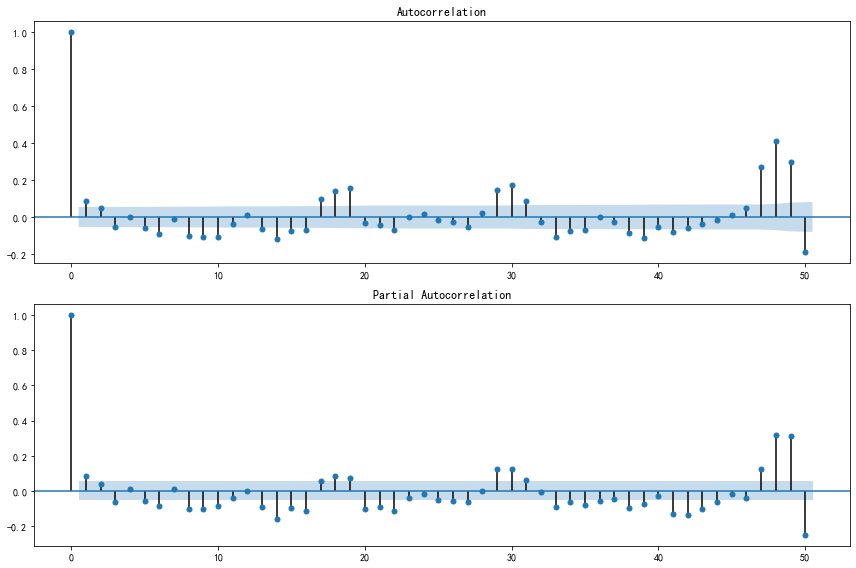

In [12]:
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(diff_50,lags = 50,ax=ax1)
ax1.xaxis.set_ticks_position('bottom')
fig.tight_layout()
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(diff_50, lags = 50,ax=ax2)#图中是0阶截尾
ax2.xaxis.set_ticks_position('bottom')
fig.tight_layout()
plt.show()

In [17]:
#模型定阶，根据aic、bic、hqic，三者都是越小越好
arma_mod01=sm.tsa.ARIMA(df.iloc[:,1],(0,1,0)).fit()
print(arma_mod01.aic,arma_mod01.bic,arma_mod01.hqic)
arma_mod10=sm.tsa.ARIMA(df.iloc[:,1],(1,1,0)).fit()
print(arma_mod10.aic,arma_mod10.bic,arma_mod10.hqic)
arma_mod60=sm.tsa.ARIMA(df.iloc[:,1],(0,1,1)).fit()
print(arma_mod60.aic,arma_mod60.bic,arma_mod60.hqic)
arma_mod61=sm.tsa.ARIMA(df.iloc[:,1],(1,1,1)).fit()
print(arma_mod61.aic,arma_mod61.bic,arma_mod61.hqic)
arma_mod211=sm.tsa.ARIMA(df.iloc[:,1],(2,1,1)).fit()
print(arma_mod211.aic,arma_mod61.bic,arma_mod61.hqic)
arma_mod212=sm.tsa.ARIMA(df.iloc[:,1],(2,1,2)).fit()
print(arma_mod212.aic,arma_mod61.bic,arma_mod61.hqic)
arma_mod112=sm.tsa.ARIMA(df.iloc[:,1],(1,1,2)).fit()
print(arma_mod112.aic,arma_mod61.bic,arma_mod61.hqic)

1910.6871526806615 1921.0924750737079 1914.5849549541058
1583.6060252139532 1599.214008803523 1589.4527286241196
1738.909587413525 1754.5175710030949 1744.7562908236914
1461.1337724336513 1481.9444172197443 1468.9293769805397
1373.9021387719995 1481.9444172197443 1468.9293769805397
1375.8574595223731 1481.9444172197443 1468.9293769805397
1385.275164379515 1481.9444172197443 1468.9293769805397


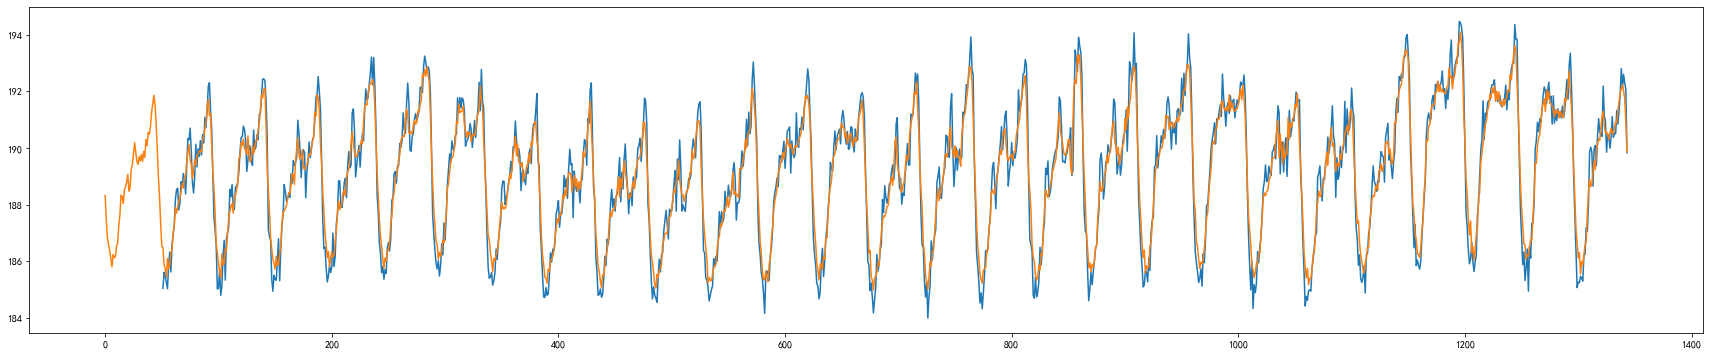

In [43]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(df.iloc[:,1], order=(2, 1, 1))
results = model.fit()
predict_ = results.predict()#predict中进行预测的时间段在训练ARIMA模型的数据中，forecast对训练数据集末尾下一个时间段的值进行预估

#预测值还原
diff1_50_shift=diff_1.shift(50)
diff_recover_50=predict_.add(diff1_50_shift)
#一阶差分还原
diff1_shift=df.iloc[:,1].shift(1)
diff_recover_1=diff_recover_50.add(diff1_shift)
diff_recover_1=diff_recover_1.dropna() # 最终还原的预测值

fig, ax = plt.subplots(figsize=(30,6))
ax = diff_recover_1.plot(ax=ax)
df.iloc[:,1].plot(ax=ax)
plt.show()

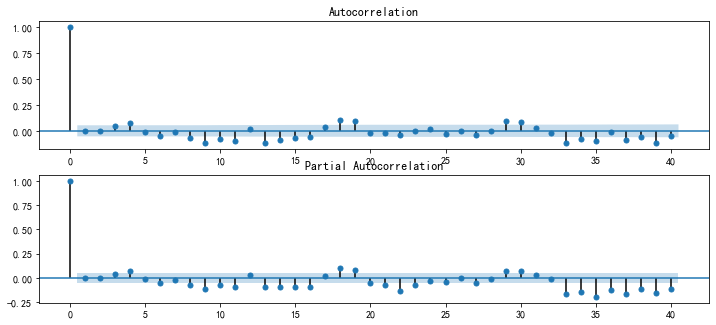

In [39]:
import scipy.stats as stats
#计算残差
resid=results.resid

#模型检验
#残差的acf和pacf
fig=plt.figure(figsize=(12,8))
ax1=fig.add_subplot(311)
fig=sm.graphics.tsa.plot_acf(resid.values.squeeze(),lags=40,ax=ax1) #squeeze()数组变为1维
ax2=fig.add_subplot(312)
fig=sm.graphics.tsa.plot_pacf(resid,lags=40,ax=ax2)
#残差自相关图断尾，所以残差序列为白噪声


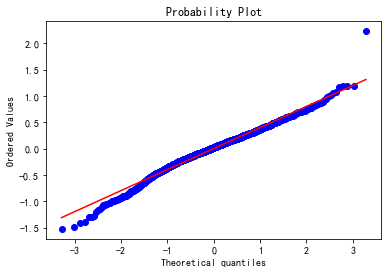

1.9967629348800222


In [38]:
fig=stats.probplot(resid,dist="norm", plot=plt)
plt.show()
print(sm.stats.durbin_watson(resid))#DW值接近于２时，说明残差不存在（一阶）自相关性